In [1]:
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search, Q

## Connection

See: https://www.tutorialspoint.com/elasticsearch/elasticsearch_query_dsl.htm

To verify these tests, use the kabana interface on tab.us.cray.com:30601

In [2]:
client =  Elasticsearch("http://tab.us.cray.com:30200", http_compress=True)

In [3]:
import pandas as pd
from pandasticsearch import Select, DataFrame
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [8]:
client.nodes.info(metric='os', flat_settings='true')['nodes']

{'4gVqn8_OTmyjJgE9TaIKOg': {'name': '4gVqn8_',
  'transport_address': '127.0.0.1:9300',
  'host': '127.0.0.1',
  'ip': '127.0.0.1',
  'version': '5.6.4',
  'build_hash': '8bbedf5',
  'roles': ['master', 'data', 'ingest'],
  'os': {'refresh_interval_in_millis': 1000,
   'name': 'Linux',
   'arch': 'amd64',
   'version': '4.4.155-94.50-default',
   'available_processors': 1,
   'allocated_processors': 1}}}

Get the cluster health

In [9]:
client.cluster.health()

{'cluster_name': 'elasticsearch',
 'status': 'yellow',
 'timed_out': False,
 'number_of_nodes': 1,
 'number_of_data_nodes': 1,
 'active_primary_shards': 196,
 'active_shards': 196,
 'relocating_shards': 0,
 'initializing_shards': 0,
 'unassigned_shards': 196,
 'delayed_unassigned_shards': 0,
 'number_of_pending_tasks': 0,
 'number_of_in_flight_fetch': 0,
 'task_max_waiting_in_queue_millis': 0,
 'active_shards_percent_as_number': 50.0}

In [10]:
client.info()

{'name': '4gVqn8_',
 'cluster_name': 'elasticsearch',
 'cluster_uuid': 'kZ8AiENRQAO7zsv-BYS-ew',
 'version': {'number': '5.6.4',
  'build_hash': '8bbedf5',
  'build_date': '2017-10-31T18:55:38.105Z',
  'build_snapshot': False,
  'lucene_version': '6.6.1'},
 'tagline': 'You Know, for Search'}

Convert the result to Pandas Dataframe

In [4]:
res = client.search(index='shasta-logs-2019.07.13', body={"query":{"match_all":{}}},size=10000)

__Note:__ the hostname field is really the k8s pod name, severlity is always 'debug' and stream is either stderr or stdout.

So searching for annomalies is going to be hard...

In [5]:
dfs = Select.from_dict(res).to_pandas()

Some of these fields are not required, so lets delete a few, keeping the following.

In [23]:
#print(dfs.head(1))
dfs.columns

                    _id                  _index  _score   _type facility  \
0  AWvo3hiUP3Cwdi_pGsBb  shasta-logs-2019.07.13     1.0  events   local0   

                                            hostname  \
0  nms-rosebud-78f7649959-2nkxn_default_nms-roseb...   

                              message priority procid severity  stream  \
0  I│  │ Cookie: 0x0000000000000025\n      135    NaN    debug  stderr   

                tag                    timereported  
0  docker_container  2019-07-13T01:06:28.329078715Z  


Index(['_id', '_index', '_score', '_type', 'facility', 'hostname', 'message',
       'priority', 'procid', 'severity', 'stream', 'tag', 'timereported'],
      dtype='object')

Iterate through each row

In [34]:
#for _index, row in dfs.iterrows():
#    print(_index, row['message'])

Grap the last __2__ lines of stderr messages

In [31]:
dfs.loc[dfs['stream'] == 'stderr','message'].head(2)

0    I│  │ Cookie: 0x0000000000000025\n
1              I│  │ Table : Table(2)\n
Name: message, dtype: object

In [59]:
msg=dfs.loc[dfs['stream'] == 'stderr','message']
print(msg.describe())
%timeit msg.str.contains(r'Table',regex=False).describe()

count                        7870
unique                       1705
top       I│  │    │    │    └─\n
freq                          416
Name: message, dtype: object
4.23 ms ± 138 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


All frequencies
                                                 Word  Frequency
0                             I│  │    │    │    └─\n        416
1                             I│  │    │    │    ┌─\n        409
2   I│  │    │    │    │ Class: XMClassOpenflowBas...        365
3                                  I│  │    │    └─\n        266
4                                        I│  │    │\n        208
5                                         I│  │    \n        203
6                                       I│  │    └─\n        198
7                                            I│  └─\n        147
8                       I│  │    │ VLAN Access List\n        138
9   I│  │    │ Attributes          : [[type pica8]...        135
10                                    I│  │    ┬───\n        131
11                      I│  │    │ ───┬────────────\n        130
12                              I│  │    │    │ 100\n        129
13                                             I│  \n        127
14       

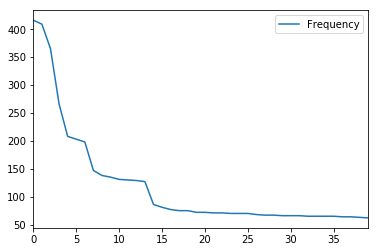

In [25]:
import nltk
top_N = 40
messages=dfs.loc[dfs['stream'] == 'stderr','message']
word_dist = nltk.FreqDist(messages)
print('All frequencies')
print('='*60)
rslt=pd.DataFrame(word_dist.most_common(top_N),columns=['Word','Frequency'])

print(rslt)
print ('='*60)
rslt.plot()
plt.show()

In [27]:
dfs.describe()

,_score
count,10000.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


In [28]:
dfs.head(3)

,_id,_index,_score,_type,facility,hostname,message,priority,procid,severity,stream,tag,timereported
0,AWvo3hiUP3Cwdi_pGsBb,shasta-logs-2019.07.13,1.0,events,local0,nms-rosebud-78f7649959-2nkxn_default_nms-roseb...,I│ │ Cookie: 0x0000000000000025\n,135,NaN,debug,stderr,docker_container,2019-07-13T01:06:28.329078715Z
1,AWvo3hiUP3Cwdi_pGsBc,shasta-logs-2019.07.13,1.0,events,local0,nms-rosebud-78f7649959-2nkxn_default_nms-roseb...,I│ │ Table : Table(2)\n,135,NaN,debug,stderr,docker_container,2019-07-13T01:06:28.329094965Z
2,AWvo3hiUP3Cwdi_pGsBi,shasta-logs-2019.07.13,1.0,events,local0,nms-rosebud-78f7649959-2nkxn_default_nms-roseb...,I│ │ │ Switch Port Number : 5\n,135,NaN,debug,stderr,docker_container,2019-07-13T01:06:28.3306389Z


## Links
https://www.youtube.com/watch?v=vmEHCJofslg&t=1487s
https://www.youtube.com/watch?v=DamIIzp41Jg&t=461s

list all the indices 

In [ ]:
indices=client.indices.get_alias()
for idx in indices:
    # Count the number of errors, warnings, info for each log report
    errors = client.search(index=idx, body={"query":{"match":{"severity":"error"}}})
    if (len(errors['hits']['hits']) != 0):
        print("index:%s No of errors:%d" % (idx,len(errors['hits']['hits'])))
    warnings = client.search(index=idx, body={"query":{"match":{"severity":"warnings"}}})
    if (len(warnings['hits']['hits']) != 0):
        print("index:%s No of warnings:%d" % (idx,len(warnings['hits']['hits'])))
    info = client.search(index=idx, body={"query":{"match":{"severity":"info"}}})
    if (len(info['hits']['hits']) != 0):
        print("index:%s No of info:%d" % (idx,len(info['hits']['hits'])))
    debug = client.search(index=idx, body={"query":{"match":{"severity":"debug"}}})
    if (len(debug['hits']['hits']) != 0):
        print("index:%s No of debug:%d" % (idx,len(debug['hits']['hits'])))
    #print("Found %d hits" % res['hits']['total'])

In [ ]:
res = client.search(index='shasta-logs-2019.07.13', body={"query":{"match_all":{}}})
print("Found %d hits" % res['hits']['total'])

for hit in res['hits']['hits']:
    print(hit)
    #print("%(timereported)s" % hit["_source"])

In [ ]:
print(res.keys())

In [ ]:
print(res['hits'].keys())

In [ ]:
print(len(res['hits']['hits']))

In [ ]:
print(res['hits']['hits'][0].keys())

In [ ]:
print(res['hits']['hits'][0]['_source'].keys())

In [ ]:
resp= client.count(
    index="shasta-logs-2019.07.17",
    body={
        "query": {
            "bool": {
                "must": [{
                    "match": {
                        "severity": "debug"
                    }
                }],
                "filter":{
                    "term": {
                        "stream" : "stderr"
                    }
                }
            }
        }
    }
)
resp

In [ ]:
tmp=client.search(index='shasta-logs-2019.07.17')
sz=tmp['hits']['total']
print(sz)
errors=client.search(index='shasta-logs-2019.07.17', body={"query":{"match":{"severity":"debug"}}}, size=10000)
print(len(errors['hits']['hits']))
errors

In [ ]:
def df_from_elastic_query(elastic_search_query):
    try:
        return pd.DataFrame.from_dict([item['_source'] for item in elastic_search_query['hits']['hits']])
    except:
        return pd.DataFrame()

In [ ]:
df_from_elastic_query(client.search(index='shasta-logs-2019.07.13', body={
    "query": {
        "match": { 
            "severity": "debug"
        }
    }
}, size=10*1000)).head()

In [ ]:
df_from_elastic_query(client.search(index='shasta-logs-2019.07.13', body={
    "query": {
        "multi_match": { 
            "query": "error",
            "fields": ["message"]
        }
    }
}, size=10*1000)).head()

In [ ]:
df_from_elastic_query(client.search(index='shasta-logs-2019.07.13', body={
    "query": {
        "query_string": { 
            "query": "error"
        }
    }
}, size=10*1000)).head()